https://heegyukim.medium.com/korean-smilestyle-dataset%EC%9C%BC%EB%A1%9C-%EB%AC%B8%EC%B2%B4-%EC%8A%A4%ED%83%80%EC%9D%BC%EC%9D%84-%EB%B0%94%EA%BE%B8%EB%8A%94-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EA%B8%B0-d15d32a2c303

# SmileGate Style Dataset을 이용한 텍스트 스타일 변경 모델

- https://github.com/smilegate-ai/korean_smile_style_dataset

In [ ]:
!pip install transformers
!pip install --upgrade accelerate 
!wget https://raw.githubusercontent.com/smilegate-ai/korean_smile_style_dataset/main/smilestyle_dataset.tsv

In [2]:
from transformers import (
    AutoConfig, AutoTokenizer, TextDataset, DataCollatorForLanguageModeling,
    PreTrainedTokenizer,
    Trainer, TrainingArguments,AutoModelWithLMHead
)
from typing import Dict, List, Optional
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import display
from typing import Dict

In [3]:
df = pd.read_csv("smilestyle_dataset.tsv", sep="\t")
display(df.head())
display(df.isna().mean())
display(df.describe())
print(df.shape)

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
0,안녕하세요. 저는 고양이 6마리 키워요.,안녕! 나는 고양이 6마리 키워.,휴먼. 반갑다. 안드로이드는. 고양이. 6마리. 소유중.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하잉ㅋㅋ 나 떼걸룩 6마리 키운다!,ㅎㅇ 나 주인님 6마리 모심 ㅋㅋ,안녕!! >< 나는 고양이😺를 ➏ 마리 키우고있어!! 0_0,안녕안녕~! 나 고양이 6마리나 키운다? 완전 대박이징~,"안녕하십니까,, 저는 고양이 6마리 키웁니다.",안녕하신가~... 난 지금 고양이를 6마리 키우고 있다네,하유 시벌것 괭이놈 6마리 키우는데 힘들어 죽겟네,안녕하냐 ㅡㅡ 나 씹냥이 6마리나 키운다 하;,반갑소. 짐은 고양이를 6마리나 키우오.,안녕하냐니깐! 난 고양이를 6마리 키우고있다니깐!,안녕하시오! 소인은 고양이를 6마리 키우고 있소!,안녕… 난 고양이 6마리 키워 ㅠㅠ,반가운. 나는 6마리의 고양이를 소지하고 있다.
1,고양이를 6마리나요? 키우는거 안 힘드세요?,고양이를 6마리나? 키우는거 안 힘들어?,고양이. 6마리. 양육. 번거로운가.,아니 무슨 고양이를 6마리나? 거 키우는 거 안 힘든가?,엥? 6마리나? 안힘듬?ㅋㅋㅋㅋ,6마리? 에바아니냐 안 힘듦?,고양이를 6마리나?!! w(ﾟДﾟ)w 키우는거 안 힘듬?? (⊙_⊙;),고양이를 6마리나? 완전 대박~ 키우는 거 안 힘들어?!,"고양이를 6마리나 키우십니까? 안 힘드신지,,",고양이를 6마리나? 키우는거 힘들지 않는가?,니기럴 털만 날리는 거 키우기 안 힘들데?,아니 고양이를 6마리나? 안힘드냐?,고양이를 6마리나? 키우는게 수고스럽진 않소?,고양이를 6마리나? 키우는거 힘들지 않냐니깐?,고양이를 6마리나 키우고 있는 것이오? 힘들지 않소?,고양이..6마리나? ㅠ 키우는건 혹시 안힘들어..?,6마리의 고양이? 당신은 그들로부터 지치지 않습니까?
2,제가 워낙 고양이를 좋아해서 크게 힘들진 않아요.,내가 워낙 고양이를 좋아해서 크게 힘들진 않아.,안드로이드. 고양이. 선호. 힘들지. 않음.,내가 또 워~낙에 고양이를 좋아해서 크게 뭐 힘들진 않고,내가 고양이 좋아해서 딱히 안힘듬 ㅋㅋㅋ,ㄱㅊ 나 고양이 환장해서 힘든 것도 모름,뭐 나야 워낙에 고양이 좋아하니까 딱히 안힘드엉! \(@^0^@)/,내가 또 워~낙에 고양이를 좋아하잖아~ 그렇게 크~게 힘들진 않아 ㅎㅎ~,제가 워낙 고양이를 좋아해서 크게 힘들진 않습니다.,내가 워낙에...고양이가 좋아가지고 그렇게 힘들지 않어...^^,옘병 내가 좋아하니까 키워야지 시벌것,고양이 좋아한다고ㅡㅡ 1도 안힘듬 ㅡㅡ,과인은 고양이를 어여삐 어겨 그리 수고스럽진 않소,내가 고양이를 엄청 좋아해서 별로 힘들지 않다니깐!,소인 고양이를 엄청 좋아하기 때문에 별로 힘들지 않소이다.,내가 고양이 워낙 좋아해서..ㅠㅠ 크게 힘들진 않은 것 같아..,나는 고양이의 큰 애호가. 지치지 않는다.
3,가장 나이가 많은 고양이가 어떻게 돼요?,가장 나이가 많은 고양이가 몇 살이야?,제일. 나이많은. 고양이. 나이. 무엇.,그려 가장 나이가 많은 고양이가 몇살이여?,가장 나이 먹은 고양이가 몇살이야?,젤 낡은 고영희가 몇 살임?,가장 나이 먹은 고양인 몇 살이양? (´･ω･`)?,대박대박 완전 대박!! 그럼 제~일 나이 많은 고양이는 몇살이야~?!,가장 나이가 있는 고양이가 몇살입니까?,고양이들 중에서…가장 나이 먹을 애가 몇살인가?...,거 젤 빨리 뒤질 놈이 나이 얼마나 쳐먹었냐,가장 늙은애가 몇살인데,최고령 고양이의 나이는 어떻게 되는가?,가장 나이 많이 먹은 고양이가 몇 살 이냐니깐?!,나이를 가장 많이 먹은 고양이가 몇 살이오?,혹시.. 제일 나이 많은 고양이는.. 몇살이야..?ㅠ,가장 늙은 고양이가 몇 년입니까?
4,여섯 살입니다. 갈색 고양이에요.,여섯 살이야. 갈색 고양이지.,고양이. 갈색. 여섯살.,6살인데 갈색 고양이 있어~,이제 여섯살이고 갈색고양이임!,"6살, 갈색임",여설 살!! ㄱ^o^/ 색깔은 갈색! O(*￣▽￣*)ブ,"6살인 애 있는데, 완전 귀.여.워. 갈색 고양이야 진짜 대박이지?",6살된 갈색 아이가 있습니다.,저…갈색 고양이인데…여섯살이지~..,저 노망난 갈색놈이 6살 뒤룩뒤룩 쳐먹은 놈이여,여섯살 갈색냥인데 왜,여섯 살이오. 갈색 고양이오.,갈색 고양이가 여섯살이라니깐!,여섯 살에 갈색 고양이오,여섯살이야.. 갈색 ㅠㅠ 고양이야..ㅠ,여섯. 고양이는 갈색이다.


formal        0.063428
informal      0.063428
android       0.520918
azae          0.723347
chat          0.063428
choding       0.063428
emoticon      0.514980
enfp          0.544130
gentle        0.540351
halbae        0.515789
halmae        0.726586
joongding     0.063428
king          0.520918
naruto        0.514980
seonbi        0.514980
sosim         0.520918
translator    0.594062
dtype: float64

,formal,informal,android,azae,chat,choding,emoticon,enfp,gentle,halbae,halmae,joongding,king,naruto,seonbi,sosim,translator
count,3470,3470,1775,1025,3470,3470,1797,1689,1703,1794,1013,3470,1775,1797,1797,1775,1504
unique,3430,3417,1748,1025,3437,3390,1793,1679,1691,1784,1005,3396,1759,1779,1784,1758,1489
top,안녕하세요.,안녕.,반갑다.,아이고 안녕하십니까~ 나는 그냥 고양이 6마리 키우고 있는 사람이여,하이,왜?,안녕! (ﾉ*･ω･)ﾉ,안뇽~,안녕하십니까,안녕하신가…,왜 땜시?,ㅎㅇ,반갑소.,안녕하냐니깐!,안녕하시오!,안녕..,반가운.
freq,23,25,10,1,13,37,3,6,5,8,4,29,7,9,9,9,9


(3705, 17)


2개 이상의 열이 NaN이 아니어야 하는데, 이 조건을 만족하지 못하는 row를 찾아내서 제외한다. 3475행이 3470행으로 바뀌었다.

In [4]:
row_notna_count = df.notna().sum(axis=1)
row_notna_count

0       17
1       17
2       17
3       17
4       17
        ..
3700     5
3701     5
3702     5
3703     5
3704     5
Length: 3705, dtype: int64

In [5]:
row_notna_count.max()

17

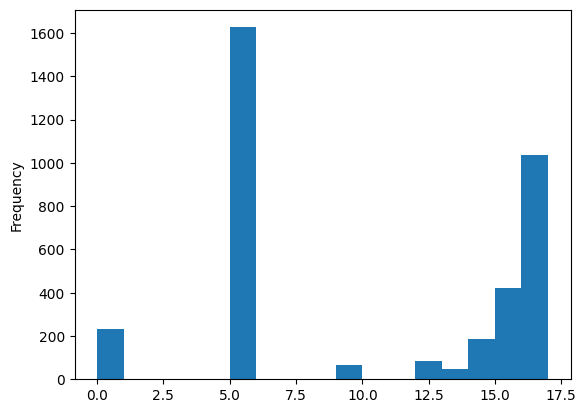

In [7]:
row_notna_count = df.notna().sum(axis=1)
row_notna_count.plot.hist(bins=row_notna_count.max())
plt.show()

In [8]:
df = df[row_notna_count >= 2]
print(len(df))

3470


# 텍스트를 토큰화했을 때 길이가 어느정도인지 확인해보기


In [9]:
model_name = "beomi/kcgpt2"
config = AutoConfig.from_pretrained(model_name, cache_dir="/content/")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [10]:
print(df['formal'][df['formal'].notna()].tolist()[:5])
print(len(df['formal'][df['formal'].notna()].tolist()))

tokenizer(df['formal'][df['formal'].notna()].tolist()[:5])

['안녕하세요. 저는 고양이 6마리 키워요.', '고양이를 6마리나요? 키우는거 안 힘드세요?', '제가 워낙 고양이를 좋아해서 크게 힘들진 않아요.', '가장 나이가 많은 고양이가 어떻게 돼요?', '여섯 살입니다. 갈색 고양이에요.']
3470


{'input_ids': [[35027, 14, 15377, 6815, 727, 5042, 9561, 561, 14], [19605, 1799, 727, 5042, 11666, 31, 16740, 521, 631, 40894, 3613, 31], [2463, 4440, 24340, 22632, 1916, 2248, 492, 33826, 14], [7262, 9089, 1373, 30733, 2481, 42140, 31], [44918, 990, 2877, 14, 17398, 6054, 15210, 14]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

In [11]:
df_dropped = df.drop(["emoticon"], axis=1)
lengths = []

for column in df_dropped.columns:
  out = tokenizer(df[column][df[column].notna()].tolist())
  out = [len(x) for x in out['input_ids']]
  lengths.extend(out)

lengths = pd.Series(lengths)

In [12]:
lengths

0         9
1        12
2         9
3         7
4         8
         ..
34991     8
34992    12
34993     7
34994    11
34995    13
Length: 34996, dtype: int64

count    34996.000000
mean        11.538604
std          5.675607
min          1.000000
25%          7.000000
50%         11.000000
75%         14.000000
max        164.000000
dtype: float64

<Axes: ylabel='Frequency'>

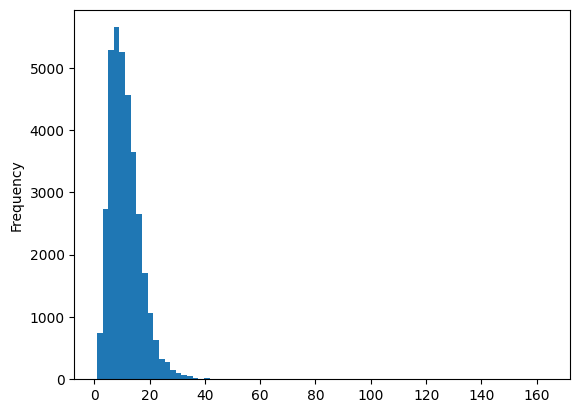

In [13]:
display(lengths.describe())
lengths.plot.hist(bins=80)

# Dataset class 만들기
EOS 토큰이 PAD 토큰이랑 동일해서 그런지, 실제 생성 과정에서는 문장이 계속 생성되서 별도로 문장의 끝을 알리는 [SEP]를 추가했습니다.

In [17]:
row = df.iloc[0, :].dropna().sample(2)
print(row)
text1 = row[0]
text2 = row[1]
target_style = row.index[1]

print(text1, text2, target_style)

informal     안녕! 나는 고양이 6마리 키워.
sosim       안녕… 난 고양이 6마리 키워 ㅠㅠ
Name: 0, dtype: object
안녕! 나는 고양이 6마리 키워. 안녕… 난 고양이 6마리 키워 ㅠㅠ sosim


In [18]:
f"{text1}[{target_style}]{text2}[SEP]"

'안녕! 나는 고양이 6마리 키워.[sosim]안녕… 난 고양이 6마리 키워 ㅠㅠ[SEP]'

In [19]:

class TextStyleTransferDataset(Dataset):
  def __init__(self, df: pd.DataFrame, tokenizer: PreTrainedTokenizer, tokenizer_params: Dict = {}):
    self.df = df
    self.tokenizer = tokenizer
    self.tokenizer_params = tokenizer_params
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = df.iloc[index, :].dropna().sample(2)
    text1 = row[0]
    text2 = row[1]
    target_style = row.index[1]

    line = f"{text1}[{target_style}]{text2}[SEP]"
    out = self.tokenizer(line, **self.tokenizer_params)

    return out

In [20]:
tokenizer_params = dict(
    return_tensors='pt',
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    max_length=50
)
dataset = TextStyleTransferDataset(df_dropped, tokenizer, tokenizer_params)
out = dataset[0]
print(out['input_ids'][0])
print(tokenizer.decode(out['input_ids'][0]))

out = dataset[1]
print(out['input_ids'][0])
print(tokenizer.decode(out['input_ids'][0]))

tensor([  276,  4204, 12480,   432,  5735,  1358,  5942,   727,  5042,  1181,
         6121, 48307,   905,    70, 34372,    61, 15626,     1,  3593,  6815,
          727,  5042,  9561, 14788,    51, 12336,    61,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
하잉ㅋㅋ 나 떼걸룩 6마리 키운다![informal]안녕! 나는 고양이 6마리 키워.[SEP]<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
tensor([ 5124, 24340,   727,  5042,   332,    31,   631,  5240,   380,  1225,
           31,    59,  2064,  2885,  1617,    61,    22,  5042,    31, 32787,
         5124,  1225,   631,  1084, 42365,    31,    59,    51, 12336,    61,
            0,     0,  

In [21]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_dropped, test_size=0.1, random_state=42)
print(len(df_train), len(df_test))

3123 347


In [23]:
tokenizer_params = dict(
    return_tensors='pt',
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    max_length=100
)
train_dataset = TextStyleTransferDataset(
    df_train,
    tokenizer,
    tokenizer_params
)
test_dataset = TextStyleTransferDataset(
    df_test,
    tokenizer,
    tokenizer_params
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

In [24]:
model = AutoModelWithLMHead.from_pretrained(model_name, cache_dir="/content/")
model.config.pad_token_id = model.config.eos_token_id

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1352: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [25]:
#model_path = "/content/drive/MyDrive/data/text-transfer-smilegate160/"
model_path = "/content/smilegate/"

training_args = TrainingArguments(
    output_dir=model_path, #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs 40
    per_device_train_batch_size=16, # batch size for training
    per_device_eval_batch_size=16,  # batch size for evaluation
    eval_steps=500, # Number of update steps between two evaluations. 
    save_steps=500, # after # steps model is saved 
    warmup_steps=300,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    evaluation_strategy="steps"
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
500,2.442400,2.517519
1000,1.963600,2.182712
1500,1.685700,2.149555


TrainOutput(global_step=1960, training_loss=1.9200691067442601, metrics={'train_runtime': 889.3586, 'train_samples_per_second': 35.115, 'train_steps_per_second': 2.204, 'total_flos': 1593779328000000.0, 'train_loss': 1.9200691067442601, 'epoch': 10.0})

In [ ]:
trainer.save_model("/content/smilegate_pretrained")

# Pipeline을 이용해서 학습한 모델로 텍스트 생성해보기

In [28]:
from transformers import pipeline

pipe = pipeline('text-generation', model=model_name, device=0)

pipe("고양이 몇마리") ## "안녕하세1요."

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


[{'generated_text': '고양이 몇마리 분양했다고 뉴스에 떠들지?'}]

In [ ]:

nlg_pipeline = pipeline('text-generation',model="/content/smilegate_pretrained", tokenizer=model_name)

In [ ]:
def filter_generated_result(text):
  return text.split("[SEP]")[0]
def generate_text(pipe, text, target_style, num_return_sequences=5):
  text = f"{text}[{target_style}]"
  out = pipe(text, num_return_sequences=num_return_sequences, 
             pad_token_id=tokenizer.eos_token_id,
             max_length=100)
  return [filter_generated_result(x['generated_text']) for x in out]

In [ ]:
src_text = "어제 먹은 밥 맛있더라"

for style in df.columns:
  print(generate_text(nlg_pipeline, src_text, style, num_return_sequences=1)[0])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


어제 먹은 밥 맛있더라[formal]어제 먹은 밥이 생각나네요.
어제 먹은 밥 맛있더라[informal]어제 먹은 밥이 또 맛있어.
어제 먹은 밥 맛있더라[android]저녁. 안음. 시간. 없음.
어제 먹은 밥 맛있더라[azae]오늘 먹은 밥이 금붕어 밥먹었네??
어제 먹은 밥 맛있더라[chat]어제 먹은 쌀맛 ㄴㄴ
어제 먹은 밥 맛있더라[choding]아침밥에 비하면 새럼 ㅋㅋ
어제 먹은 밥 맛있더라[emoticon]어제 먹은 밥이 다 차버렸다…(#Д°Д°)
어제 먹은 밥 맛있더라[enfp]어제 먹은거 토할 뻔햇엉 ㅎㅎㅜ
어제 먹은 밥 맛있더라[gentle]저희 가족은 거의 모든 밥을 먹을 수 있는 만큼 영양섭취를 잘합니다.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:4                                                                              │
│ in generate_text:5                                                                               │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_generation.py:201 in         │
│ __call__                                                                                         │
│                                                                                                  │
│   198 │   │   │   - **generated_token_ids** (`torch.Tensor` or `tf.Tensor`, present when `retu   │
│   199 │   │   │     ids of the generated text.                                                   │
│   200 │   │   """                                                                                │
│ ❱ 201 │   │   return super().__call__(text_inputs, **kwargs)                                     │
│   202 │                                                                                          │
│   203 │   def preprocess(self, prompt_text, prefix="", handle_long_generation=None, **generate   │
│   204 │   │   inputs = self.tokenizer(                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1119 in __call__          │
│                                                                                                  │
│   1116 │   │   │   │   )                                                                         │
│   1117 │   │   │   )                                                                             │
│   1118 │   │   else:                                                                             │
│ ❱ 1119 │   │   │   return self.run_single(inputs, preprocess_params, forward_params, postproces  │
│   1120 │                                                                                         │
│   1121 │   def run_multi(self, inputs, preprocess_params, forward_params, postprocess_params):   │
│   1122 │   │   return [self.run_single(item, preprocess_params, forward_params, postprocess_par  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1126 in run_single        │
│                                                                                                  │
│   1123 │                                                                                         │
│   1124 │   def run_single(self, inputs, preprocess_params, forward_params, postprocess_params):  │
│   1125 │   │   model_inputs = self.preprocess(inputs, **preprocess_params)                       │
│ ❱ 1126 │   │   model_outputs = self.forward(model_inputs, **forward_params)                      │
│   1127 │   │   outputs = self.postprocess(model_outputs, **postprocess_params)                   │
│   1128 │   │   return outputs                                                                    │
│   1129                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1025 in forward           │
│                                                                                                  │
│   1022 │   │   │   │   inference_context = self.get_inference_context()                          │
│   1023 │   │   │   │   with inference_context():                                                 │
│   1024 │   │   │   │   │   model_inputs = self._ensure_tens